# Summary:
---

1. Notebook for kmeans, pca, and tsne

### Functions Needed:

In [2]:
import pandas as pd
from Bio import SeqIO
def parseFasta(data):
    d = {fasta.id : str(fasta.seq) for fasta in SeqIO.parse(data, "fasta")}
    pd.DataFrame([d])

    s = pd.Series(d, name='Sequence')
    s.index.name = 'ID'
    s.reset_index()
    return pd.DataFrame(s)

from sklearn.feature_extraction.text import TfidfVectorizer
def kmerXTable(s, a, b):
    tfid_vector = TfidfVectorizer(analyzer='char', ngram_range=(a,b))
    s_hat = tfid_vector.fit_transform(s.Sequence)
    kmerNames = tfid_vector.get_feature_names()
    kmers = s_hat.toarray()
    return pd.DataFrame(kmers,columns=kmerNames, index = s.index)

from sklearn.cluster import KMeans
def doKmeans(rState, nClusters, data):
    km = KMeans(random_state = rState, n_clusters = nClusters)
    km.fit(data)
    return km

from sklearn.decomposition import PCA
def doPCA(data):
    embedding = PCA()
    embedding.fit(data)
    return embedding

import matplotlib.pyplot as plt
def graphPCA(pca, data, labels):
    show = pd.DataFrame(pca.transform(data))
    ax = show.plot.scatter(x=0, y=1, style="o", c=labels, cmap = "viridis", s=2)
    plt.title('PCA')
    return ax

from sklearn.manifold import TSNE
def doTSNE(rState, nComponents, data):
    tSNEembedding = TSNE(n_components= nComponents, random_state = rState)
    tSNEembedding_low = tSNEembedding.fit_transform(data)
    return tSNEembedding_low

def graphTSNE(tSNEembedding_low, labels):
    tSNEshow = pd.DataFrame(tSNEembedding_low, labels)
    ax = tSNEshow.plot.scatter(x=0, y=1, style="o", c=labels, cmap = "viridis", s=2)
    plt.title('tSNE')
    return ax

### Data Needed:

In [3]:
virus1 = parseFasta("data/Sclerotinia_biocontrol_mycovirus_nucleotide.fasta")

# put confirmed virus killers at bottom, and removed the duplicates already in the data
virus01 = parseFasta("data/mycovirus_genbank_all_refseq_nucleotide_unique.fasta")
virus01 = virus01.append(virus1)
virus01 = virus01.drop_duplicates(keep="last")

# labels for virus01
labels = [0 for x in range(343)] + [1 for x in range(7)]

# Visualization:
-----
Visualization of different kmers with PCA and tSNE

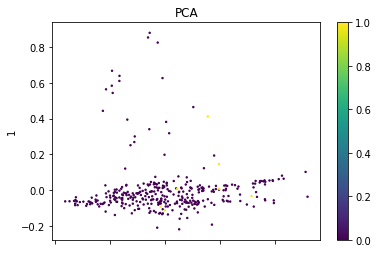

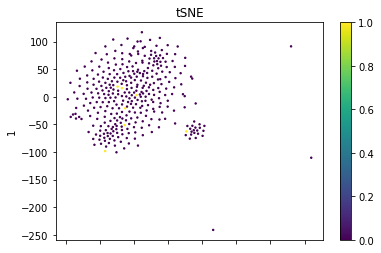

In [4]:
kmer7Table01 = kmerXTable(virus01, 7,7)
graphPCA(doPCA(kmer7Table01), kmer7Table01, labels)
graphTSNE(doTSNE(0, 2, kmer7Table01), labels)

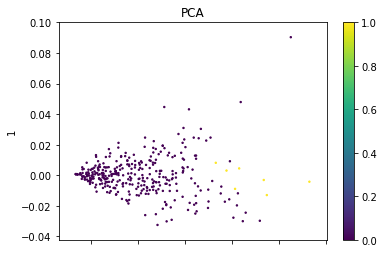

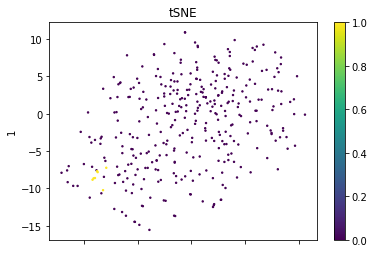

In [5]:
kmer7Table1 = kmerXTable(virus1, 7,7)
# columns that confirmed virus killers have no zeros in for kmer length 7
cols = kmer7Table1.loc[:, (kmer7Table1 == 0).any(axis=0) != True].columns
graphPCA(doPCA(kmer7Table01[cols]), kmer7Table01[cols], labels)
graphTSNE(doTSNE(0, 2, kmer7Table01[cols]), labels)

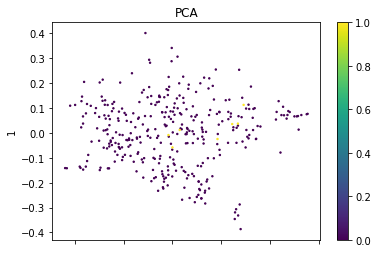

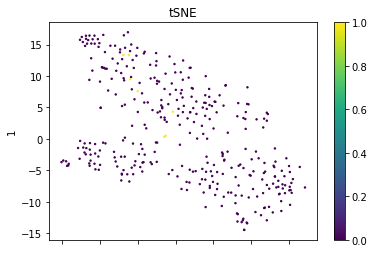

In [6]:
kmer27Table01 = kmerXTable(virus01, 2,7)
graphPCA(doPCA(kmer27Table01), kmer27Table01, labels)
graphTSNE(doTSNE(0, 2, kmer27Table01), labels)

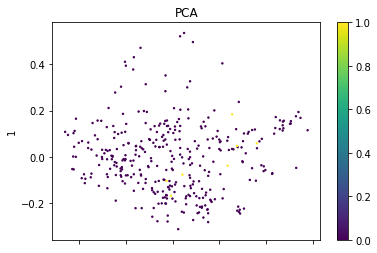

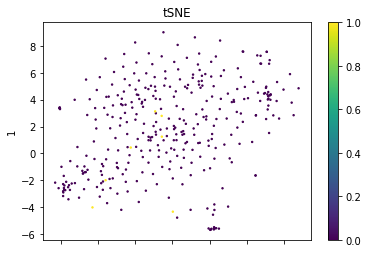

In [7]:
kmer57Table01 = kmerXTable(virus01, 5,7)
graphPCA(doPCA(kmer57Table01), kmer57Table01, labels)
graphTSNE(doTSNE(0, 2, kmer57Table01), labels)

# Kmeans with Mean Shift:
-----
The second PCA and tSNE attempt had the best results, so those kmers will be used for this

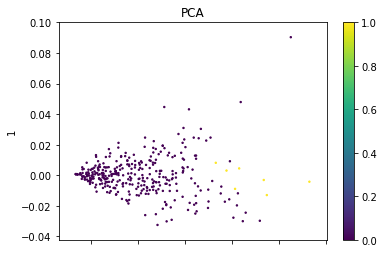

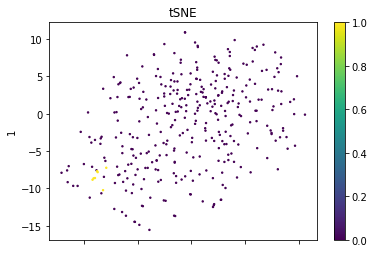

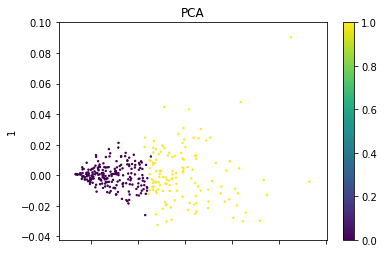

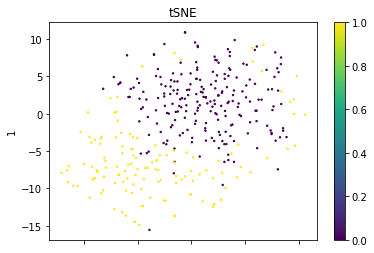

In [8]:
data = kmer7Table01[cols]
embedding = doPCA(data)
TSNEembedding = doTSNE(0, 2, data)
km1 = doKmeans(42, 2, data)

# confirmed labels
graphPCA(embedding, data, labels)
graphTSNE(TSNEembedding, labels)

# predicted labels
y_hat = km1.predict(data)
graphPCA(embedding, data, y_hat)
graphTSNE(TSNEembedding, y_hat)

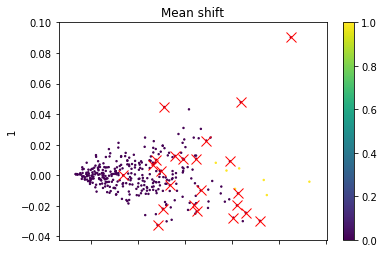

In [9]:
from sklearn.cluster import MeanShift
ms = MeanShift()
output = pd.DataFrame(embedding.transform(data))
                       
ms.fit(output)
cluster_centers = ms.cluster_centers_
ax = output.plot.scatter(x=0, y=1, style="o", c=labels, cmap = "viridis", s=2)
ax.scatter(cluster_centers[:,0], cluster_centers[:,1], marker='x', color='red', s=100, linewidth=1)
plt.title('Mean shift')
plt.show()

In [10]:
len(cluster_centers)

23

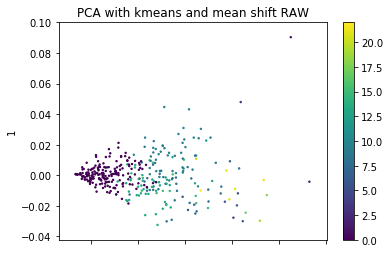

In [11]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    km2 = KMeans(init = cluster_centers, n_clusters = len(cluster_centers))
    km2.fit(data)
 
y_hat2 = km2.predict(data)
graphPCA(embedding, data, y_hat2)
plt.title('PCA with kmeans and mean shift RAW')
plt.show()

In [12]:
y_hat2[343:]

array([21,  9, 21,  2, 21, 18,  9])

In [13]:
# set above clusters to label 1, and other clusters to label 0

import numpy as np
cluster1 = y_hat2[343:]
newLabels = []

for label in y_hat2:
    if label in cluster1:
        newLabels.append(1)
    else:
        newLabels.append(0)

# original kmeans labels
#print(np.array(y_hat))
print("Original kmeans sum of 1s: ", sum(y_hat))

# kmeans with mean shift labels
#print(np.array(newLabels))
print("Kmeans with mean sift sum of 1s: ", sum(newLabels))

Original kmeans sum of 1s:  131
Kmeans with mean sift sum of 1s:  40


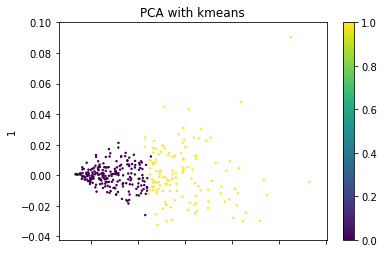

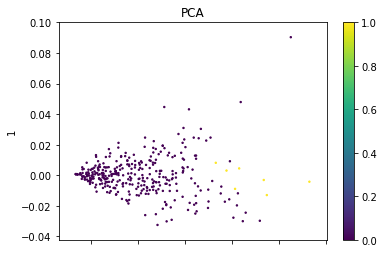

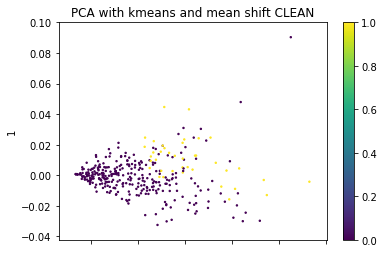

In [14]:
graphPCA(embedding, data, y_hat)
plt.title('PCA with kmeans')

graphPCA(embedding, data, labels)

graphPCA(embedding, data, newLabels)
plt.title('PCA with kmeans and mean shift CLEAN')
plt.show()

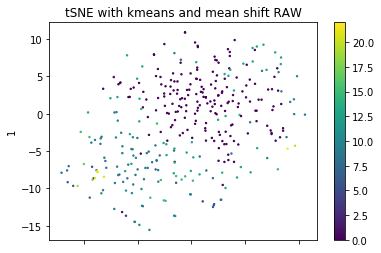

In [15]:
graphTSNE(TSNEembedding, y_hat2)
plt.title('tSNE with kmeans and mean shift RAW')
plt.show()

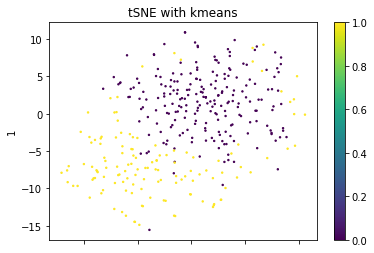

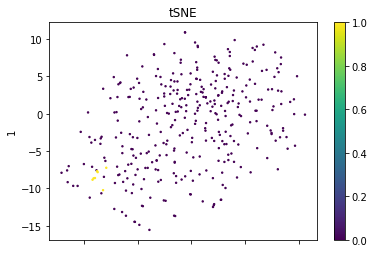

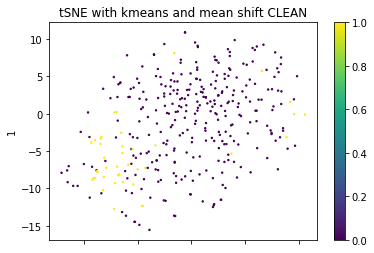

In [16]:
graphTSNE(TSNEembedding, y_hat)
plt.title('tSNE with kmeans')

graphTSNE(TSNEembedding, labels)

graphTSNE(TSNEembedding, newLabels)
plt.title('tSNE with kmeans and mean shift CLEAN')
plt.show()

# Output Dataframes:
-----

In [24]:
virus1["Kmeans and Meanshift labels"] = newLabels[343:]
virus1["Kmeans labels"] = y_hat[343:]

virus01["Kmeans and Meanshift labels"] = newLabels
virus01["Kmeans labels"] = y_hat

In [28]:
virus1.head(n=10)

,Sequence,Kmeans and Meanshift labels,Kmeans labels
ID,,,
NC_007415.1,CTTTAGTAAATACCACCGCCTCTTAATAAGTCTCGAGGCACTCCCC...,1,1
NC_015939.1,GGGGTGATGGGAAACTTACGTTTCGCCAACGTTAAGGTACTGTGAT...,1,1
NC_022896.1,TTTTTGGGGATGGTACTCTCAGGTTTGATCTTTGTAGATCCTAACT...,1,1
NC_026510.1,TTGGCTCCTGGAGACCGTTAGGTCCCCAGAAGCGGTTCAATAGAAC...,1,1
NC_027138.1,GCAATAAAAAGCACAGCCGGAAGGCTTTCTTTTTATTGCCCAGTTT...,1,1
NC_027139.1,GCAATAAAAAGCACAGCCGGAAGGCTTTCTTTTTATTGCCCAGTTT...,1,1
NC_025383.1,AGGGAGTATTATAATTACCTTCGTAGTTGTTCTTACTCTCTGGTAC...,1,1


In [27]:
virus01.head(n=10)

,Sequence,Kmeans and Meanshift labels,Kmeans labels
ID,,,
NC_000960.1,GGGGGTTAGAGAAATCTTGGGAGATTTCTATCGTCATAGACATATG...,1,1
NC_001278.1,GGGAAATTTGTGAGATTATCGCCCTAAAGGATAACTCTCATGCGGG...,0,0
NC_001492.1,GCCTATGGGTGGTCTACATAGGTGAGCATGCGTTGCTCGATATAGA...,0,1
NC_001633.1,ACAAAATAATTGAAGAAATTATTTTTGTTTTACATATTTAGATCTT...,0,1
NC_001641.1,GAATTTTTCGGTGAACCGGAATTATGTCGTCTCTGTTAAATTCATT...,0,0
NC_001782.1,GAAAAATAAAGAAATGACGAAGCCAACCCAAGTATTAGTTAGATCC...,0,0
NC_001963.1,GGATTTCACGTACAACGTAGGGTTGTCCTTACGCGTTGCGCGCAAG...,0,0
NC_001964.1,CCAGGGACCCCTGCAGCCCCCTGTTTGTCAGCGCCTGTAATAGGGT...,0,0
NC_002604.1,GATTAAATTCACATCCAACAGACACAGACACCAAACACCAAACGCC...,0,0


### Scratch Work:

In [18]:
data = kmer7Table01[cols]
ms = MeanShift()
output = pd.DataFrame(embedding.transform(data))

ms.fit(output)
cluster_centers = ms.cluster_centers_

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    km2 = KMeans(init = cluster_centers, n_clusters = len(cluster_centers))
    km2.fit(data)
    
predicted = km2.predict(data)

In [19]:
predicted[343:]

array([21,  9, 21,  2, 21, 18,  9])

In [20]:
km2.predict(kmer7Table1[cols])

array([ 8,  9,  9, 21, 21, 18,  9])

In [21]:
kmer7Table1[cols].head()

,aaaacaa,aactttt,aagatga,aatcaaa,acaaata,agaagaa,agatttc,aggaatt,aggagat,aggttga,...,tcaagga,tcacaag,tcttgga,tggaaag,tggaatt,ttcaaag,ttctttc,ttgaaga,ttggaaa,ttttgat
ID,,,,,,,,,,,,,,,,,,,,,
NC_007415.1,0.012511,0.006255,0.018766,0.012511,0.006255,0.006255,0.006255,0.006255,0.006255,0.006255,...,0.012511,0.012511,0.006255,0.012511,0.006255,0.006255,0.006255,0.012511,0.012511,0.018766
NC_015939.1,0.008311,0.004155,0.008311,0.012466,0.004155,0.024932,0.004155,0.008311,0.008311,0.004155,...,0.008311,0.004155,0.004155,0.004155,0.004155,0.004155,0.008311,0.004155,0.004155,0.016621
NC_022896.1,0.003280,0.013119,0.013119,0.003280,0.003280,0.013119,0.003280,0.009840,0.006560,0.003280,...,0.009840,0.009840,0.013119,0.009840,0.006560,0.019679,0.006560,0.016399,0.003280,0.013119
NC_026510.1,0.011075,0.022150,0.022150,0.011075,0.011075,0.011075,0.011075,0.011075,0.011075,0.011075,...,0.011075,0.011075,0.011075,0.011075,0.011075,0.022150,0.011075,0.022150,0.011075,0.011075
NC_027138.1,0.012197,0.006098,0.018295,0.018295,0.012197,0.012197,0.006098,0.012197,0.006098,0.006098,...,0.006098,0.006098,0.006098,0.006098,0.006098,0.012197,0.006098,0.012197,0.012197,0.006098


In [22]:
kmer7Table01[cols][343:].head()

,aaaacaa,aactttt,aagatga,aatcaaa,acaaata,agaagaa,agatttc,aggaatt,aggagat,aggttga,...,tcaagga,tcacaag,tcttgga,tggaaag,tggaatt,ttcaaag,ttctttc,ttgaaga,ttggaaa,ttttgat
ID,,,,,,,,,,,,,,,,,,,,,
NC_007415.1,0.015343,0.009036,0.023277,0.018405,0.009245,0.007340,0.008799,0.009160,0.007909,0.008363,...,0.016005,0.019695,0.009376,0.016727,0.008398,0.008262,0.008398,0.015115,0.016866,0.025945
NC_015939.1,0.010820,0.006372,0.010943,0.019469,0.006520,0.031056,0.006205,0.012920,0.011155,0.005898,...,0.011287,0.006945,0.006612,0.005898,0.005922,0.005826,0.011845,0.005330,0.005947,0.024396
NC_022896.1,0.004357,0.020530,0.017629,0.005227,0.005251,0.016676,0.004998,0.015609,0.008985,0.004750,...,0.013636,0.016780,0.021303,0.014251,0.009540,0.028156,0.009540,0.021464,0.004790,0.019649
NC_026510.1,0.013761,0.032418,0.027836,0.016508,0.016584,0.013166,0.015784,0.016432,0.014188,0.015002,...,0.014355,0.017665,0.016820,0.015002,0.015064,0.029639,0.015064,0.027114,0.015127,0.015514
NC_027138.1,0.015739,0.009269,0.023877,0.028320,0.018968,0.015058,0.009026,0.018793,0.008113,0.008579,...,0.008209,0.010102,0.009618,0.008579,0.008614,0.016949,0.008614,0.015505,0.017300,0.008871
